# Ternary Sentiment Classifier

## Importing the libraries 

In [1]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, LSTM, Bidirectional, SpatialDropout1D, MaxPool1D, GlobalMaxPooling1D, Embedding, Input, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
import json
import re
from matplotlib import rcParams
from sklearn.metrics import confusion_matrix, classification_report
import pickle

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

## Data Preprocessing

### Analysing the data

In [3]:
ratings = [0, 0, 0]
filename = 'yelp_academic_dataset_review.json'

with open(filename, 'r') as f:
    for line in f:
        data = json.loads(line)
        if data["stars"] <= 2.0:
            ratings[0]+=1
        if data["stars"] == 3.0:
            ratings[1]+=1
        if data["stars"] >= 4.0:
            ratings[2]+=1
print(ratings)

[1918969, 842289, 5259864]


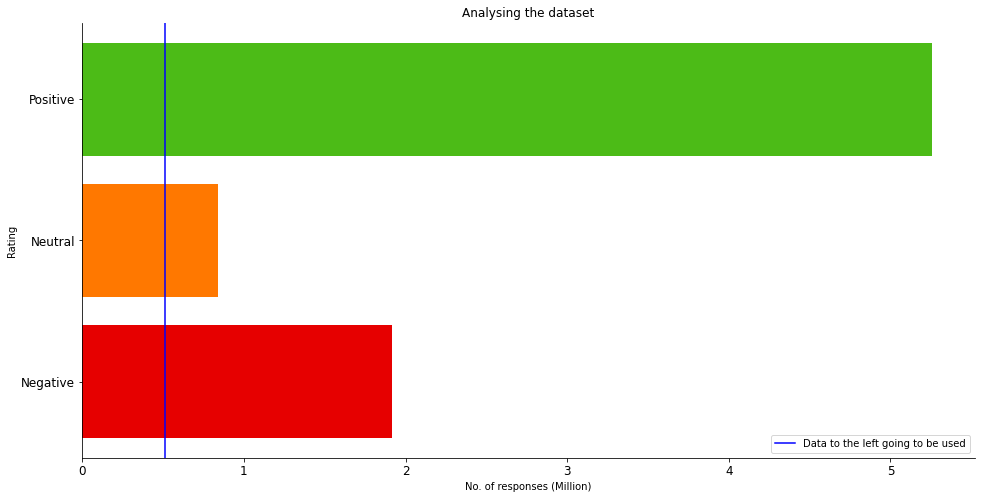

In [23]:
plt.figure(0)
plt.title('Analysing the dataset')
plt.barh(['Negative', 'Neutral', 'Positive'], [i/10**6 for i in ratings], color=['#e60000', '#ff7800', '#4cbb17'])
plt.axvline(0.512, color='b', label='Data to the left going to be used')
plt.ylabel('Rating')
plt.xlabel('No. of responses (Million)')
plt.legend()
rcParams['figure.figsize'] = 16, 8
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
plt.show()

### Getting and processing the data

In [2]:
filename = 'yelp_academic_dataset_review.json'
c1 = 0
c2 = 0
c3 = 0
reviews = []
ratings = []
max_lim = 512000
def text_cleaner(text_part):
    #removing bullet points
    text_part = re.sub("\*+\ ", "", text_part)
    #removing extra exclamations
    text_part = re.sub("!+", "!", text_part)
    #removing extra question marks
    text_part = re.sub("\?+", "?", text_part)
    #joining all different lines together
    text_part = re.sub("\n+", " ", text_part)
    #removing quotations
    text_part = re.sub("\"", "", text_part)
    #removing extra spaces
    text_part = re.sub("\ +", " ", text_part)
    text_part = text_part.lower()
    return text_part
        
with open(filename, 'r') as f:
    for line in f:
        data = json.loads(line)
        rating = data['stars']
        if rating < 3 and c1<max_lim:
            rating = 0
            c1+=1
        elif rating == 3 and c2<max_lim:
            rating = 1
            c2+=1
        elif rating > 3 and c3<max_lim:
            rating = 2
            c3+=1
        else:
            continue
        ratings.append(rating)
        text_part = data['text']
        text_part = text_cleaner(text_part=text_part)
        reviews.append(text_part)
        if c1==max_lim and c2==max_lim and c3==max_lim:
            break

In [4]:
print('Number of reviews: %d' %len(ratings))
print(reviews[0])

Number of reviews: 1536000
as someone who has worked with many museums, i was eager to visit this gallery on my most recent trip to las vegas. when i saw they would be showing infamous eggs of the house of faberge from the virginia museum of fine arts (vmfa), i knew i had to go! tucked away near the gelateria and the garden, the gallery is pretty much hidden from view. it's what real estate agents would call cozy or charming - basically any euphemism for small. that being said, you can still see wonderful art at a gallery of any size, so why the two *s you ask? let me tell you: pricing for this, while relatively inexpensive for a las vegas attraction, is completely over the top. for the space and the amount of art you can fit in there, it is a bit much. it's not kid friendly at all. seriously, don't bring them. the security is not trained properly for the show. when the curating and design teams collaborate for exhibitions, there is a definite flow. that means visitors should view the 

### Tokenizing the data

In [3]:
training_samples = int(len(ratings)*0.75)
test_samples = int(len(ratings)*0.25)
max_words = 80000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(reviews)
sequences = tokenizer.texts_to_sequences(reviews)
word_index = tokenizer.word_index
print('No. of unique tokens: %d' %(len(word_index)))

No. of unique tokens: 359612


In [4]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
maxlen = 200
dataset = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(ratings)

print('Shape of dataset: ', dataset.shape)
print('Shape of labels: ', labels.shape)

indices = np.arange(dataset.shape[0])
np.random.shuffle(indices)
dataset = dataset[indices]
labels = labels[indices]
labels = to_categorical(labels)

Shape of dataset:  (1536000, 200)
Shape of labels:  (1536000,)


In [6]:
x_train = dataset[:training_samples]
y_train = labels[:training_samples]

## Model

In [11]:
model = Sequential()
model.add(Embedding(max_words, 50, input_length=maxlen))
model.add(Conv1D(64, 7, activation='relu'))
model.add(MaxPool1D(5))
model.add(Bidirectional(LSTM(16)))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 50)           4000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 194, 64)           22464     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 38, 64)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                10368     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 4,032,931
Trainable params: 4,032,931
Non-trainable params: 0
_________________________________________________________________


In [12]:
callbacks_list = [EarlyStopping(monitor='acc', patience=1), ModelCheckpoint(monitor='val_loss', filepath='trained_model.h5', save_best_only=True)]
history = model.fit(x_train, y_train, epochs=5, batch_size=256, validation_split=0.25, callbacks=callbacks_list)

Train on 864000 samples, validate on 288000 samples
Epoch 1/5
864000/864000 [==============================] - 447s 517us/sample - loss: 0.4974 - acc: 0.7891 - val_loss: 0.4481 - val_acc: 0.8116
Epoch 2/5
864000/864000 [==============================] - 443s 513us/sample - loss: 0.4102 - acc: 0.8303 - val_loss: 0.4364 - val_acc: 0.8174
Epoch 3/5
864000/864000 [==============================] - 442s 511us/sample - loss: 0.3551 - acc: 0.8557 - val_loss: 0.4563 - val_acc: 0.8129
Epoch 4/5
864000/864000 [==============================] - 441s 510us/sample - loss: 0.2951 - acc: 0.8831 - val_loss: 0.5061 - val_acc: 0.8049
Epoch 5/5
864000/864000 [==============================] - 442s 511us/sample - loss: 0.2377 - acc: 0.9079 - val_loss: 0.5837 - val_acc: 0.7948


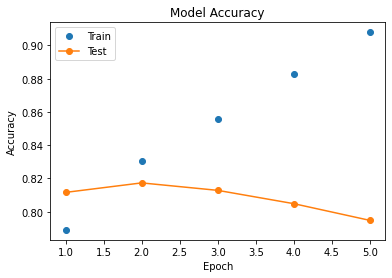

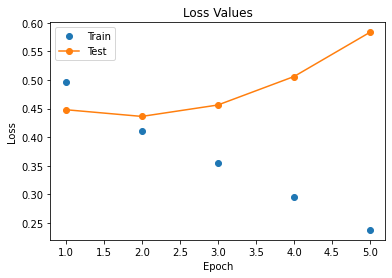

In [13]:
#Plotting Accuracy v/s Epochs
plt.figure(1)
plt.plot(range(1, len(history.history['acc'])+1), history.history['acc'], 'o', label='Train')
plt.plot(range(1, len(history.history['acc'])+1), history.history['val_acc'], '-o', label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
#Plotting Loss v/s Epochs
plt.figure(2)
plt.plot(range(1, len(history.history['acc'])+1), history.history['loss'], 'o', label='Train')
plt.plot(range(1, len(history.history['acc'])+1), history.history['val_loss'], '-o', label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Values')

plt.show()

## Testing the model

In [14]:
trained_model = load_model('trained_model.h5')
x_test = dataset[training_samples:training_samples + test_samples]
y_test = labels[training_samples:training_samples + test_samples]
results = trained_model.evaluate(x_test, y_test, batch_size=128)
print('Loss and Accuracy: ', results[0], results[1]*100)

384000/384000 [==============================] - 43s 113us/sample - loss: 0.4396 - acc: 0.8166
Loss and Accuracy:  0.43957895634075006 81.65963292121887
